In [1]:
!pip install pillow -q
!pip install datasets -q
!pip install torch -q
!pip install torchvision -q
!pip install matplotlib -q
!pip install datasets -q
!pip install torchmetrics -q
!pip install timm -q

In [2]:
from datasets import load_dataset
import PIL
import torch
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import os
import timm
from timm.loss import SoftTargetCrossEntropy
import pickle
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Global

In [3]:
torch.backends.cudnn.benchmark = True

NUM_CLASSES = 200
BATCH_SIZE = 64  
NUM_EPOCHS = 10  
LEARNING_RATE = 1e-4  
WEIGHT_DECAY = 0.01  
IMAGE_SIZE = 384
LOG_INTERVAL = 100 
DATA_DIR = "data/"
MODEL_DIRS = DATA_DIR+"models/"
TRAIN_DATA = DATA_DIR+"train.pkl"
VALID_DATA = DATA_DIR+"valid.pkl"

# Utils

In [4]:
class TorchDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform=transform

    def __repr__(self):
        return str(self.hf_dataset)

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        example = self.hf_dataset[idx]
        image = example['image']
        if self.transform:
            image =  self.transform(image)
        return image, example['label']

In [5]:
def gen_super_tiny(dataset, split, q=10, p=0, step=500, classes=200):
    from datasets import Dataset
    images_per_class = {"validation":50,
                       "test":50,
                       "train":500
                       }
    dataset_length = images_per_class[split]*classes
    t = [dataset[p+i:i+q] for i in range(0, dataset_length-q, step)]
    all_images = [image for image_class_dict in t for image in image_class_dict["image"]]
    all_labels = [image for image_class_dict in t for image in image_class_dict["label"]]
    return Dataset.from_dict({"image":all_images, "label":all_labels})

In [110]:
def print_patches(image_unfolded):
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid
    visualize = v2.Compose([v2.ToPILImage(), v2.Resize((100,100))])
    if len(image_unfolded.shape) == 5:
        image_unfolded = image_unfolded[None,:,:,:,:,:]
    for i in range(image_unfolded.shape[0]):
        n_channels, n_patches_h, n_patches_w, h, w = image_unfolded.shape[1:]
        patches = image_unfolded[i].permute(1, 2, 0, 3, 4).reshape(-1, n_channels, h, w)
        for patch in patches:
            visualize(patch).show()

# Data

Loading dataset

In [6]:
try:
    train_dataset = pickle.load(open(TRAIN_DATA,"rb"))
    valid_dataset = pickle.load(open(VALID_DATA,"rb"))
except:
    train_dataset = load_dataset('Maysee/tiny-imagenet', split='train')
    valid_dataset = load_dataset('Maysee/tiny-imagenet', split='valid')
    pickle.dump(train_dataset, open(TRAIN_DATA,"wb"))
    pickle.dump(valid_dataset, open(VALID_DATA,"wb"))

#### Data Augmentation and Transformations

In [225]:
transform_train = v2.Compose([
    v2.Lambda(lambda x: x.convert('RGB')),  # some images are in grayscale
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(),
    v2.RandAugment(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.RandomErasing(p=0.25),

])

transform_valid = v2.Compose([
    v2.Lambda(lambda x: x.convert('RGB')),  # some images are in grayscale
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [298]:
train_loader = torch.utils.data.DataLoader(
    TorchDatasetWrapper(train_dataset, transform_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,  
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)

val_loader = torch.utils.data.DataLoader(
    TorchDatasetWrapper(valid_dataset, transform_valid),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,  
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)
next(iter(val_loader))

[tensor([[[[ 2.0777,  2.1290,  2.1462,  ...,  2.2318,  2.2318,  2.2318],
           [ 2.1633,  2.1462,  2.1633,  ...,  2.2318,  2.2318,  2.2318],
           [ 2.1975,  2.1975,  2.1633,  ...,  2.2147,  2.2147,  2.2147],
           ...,
           [ 1.2728,  1.9578,  2.2318,  ...,  1.6838,  1.6667,  1.5982],
           [ 2.0434,  2.0777,  1.8037,  ...,  2.1462,  2.1119,  1.9920],
           [ 2.0092,  1.9407,  2.0263,  ...,  2.2318,  2.2318,  2.1975]],
 
          [[ 2.4111,  2.4111,  2.4286,  ...,  2.4111,  2.4111,  2.4111],
           [ 2.4286,  2.4286,  2.4111,  ...,  2.4111,  2.4111,  2.4111],
           [ 2.4286,  2.4286,  2.4111,  ...,  2.3936,  2.3936,  2.3936],
           ...,
           [ 1.4482,  2.1485,  2.4286,  ...,  1.8508,  1.8333,  1.7633],
           [ 2.4286,  2.4286,  2.1835,  ...,  2.3235,  2.2885,  2.2185],
           [ 2.4286,  2.4286,  2.4286,  ...,  2.4111,  2.4111,  2.4286]],
 
          [[ 2.5703,  2.5877,  2.6051,  ...,  2.6226,  2.6226,  2.6226],
           [ 

In [9]:
# Mixup and CutMix
mixup_fn = timm.data.Mixup(
    mixup_alpha=0.8,
    cutmix_alpha=1.0,
    cutmix_minmax=None,
    prob=0.5,  # Reduced probability to allow some original images
    switch_prob=0.5,
    mode='batch',
    label_smoothing=0.1,
    num_classes=NUM_CLASSES
)

# Model

In [275]:
model = timm.create_model('vit_base_patch16_384', pretrained=True, num_classes=NUM_CLASSES)

#### Adjust patch embeddings(conv2d) by averaging

In [276]:
patch_kernels = model.patch_embed.proj.weight
patch_kernels.shape

torch.Size([768, 3, 16, 16])

In [277]:
visualize = v2.Compose([v2.ToPILImage(), v2.Resize((100,100))])
visualize(patch_kernels[59]).save(DATA_DIR+"original.jpg")
patch_kernels[2].shape

torch.Size([3, 16, 16])

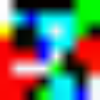

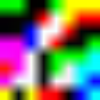

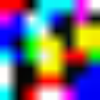

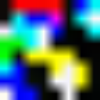

torch.Size([3, 2, 2, 8, 8])

In [278]:
patches = patch_kernels[59].unfold(1,8,8).unfold(2,8,8)
print_patches(patches)
patches.shape

torch.Size([768, 3, 2, 2, 8, 8])
torch.Size([768, 4, 3, 8, 8])


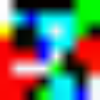

In [279]:
unfolded_patch_kernels = patch_kernels.unfold(2,8,8).unfold(3,8,8)
print(unfolded_patch_kernels.shape)
divided_patch_kernels = unfolded_patch_kernels.permute(0, 2, 3, 1, 4, 5).reshape(768, -1, 3, 8, 8)
print(divided_patch_kernels.shape)
visualize(divided_patch_kernels[59][0]).show()

In [280]:
averaged_patch_kernels = divided_patch_kernels.mean(dim=1)
print(averaged_patch_kernels.shape)
visualize(averaged_patch_kernels[59]).save(DATA_DIR+"mean_patches.jpg")

torch.Size([768, 3, 8, 8])


In [281]:
model.patch_embed.proj

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [282]:
pos_embeddings = model.pos_embed
pos_embeddings.shape

torch.Size([1, 577, 768])

#### Another solution would be using maxpool

In [283]:
patch_kernels = model.patch_embed.proj.weight
patch_kernels.shape

torch.Size([768, 3, 16, 16])

In [284]:
max_pool = torch.nn.MaxPool2d(2, stride=2)
maxpooled = max_pool(patch_kernels)

In [285]:
visualize(maxpooled[59]).save(DATA_DIR+"maxpool.jpg")

or bicubic interpolation

In [286]:
interpooled_patch_embedding = torch.nn.functional.interpolate(patch_kernels, size=(8,8), mode="bicubic")
visualize(interpooled_patch_embedding[59]).save(DATA_DIR+"bicubic.jpg")

In [287]:
mean_pool = torch.nn.AvgPool2d(2, stride=2)
mean_pooled = mean_pool(patch_kernels)
visualize(mean_pooled[59]).save(DATA_DIR+"averagepool.jpg")

#### Interpolate 

#### Training loop

In [294]:
pos_embed = model.pos_embed
print(pos_embed.shape)
pos_embed = pos_embed.reshape(577, 768)
cls_pos_embedding, pos_embed = torch.split(pos_embed, [1, 576])
pos_embed = pos_embed.reshape(24, 24, 768).permute(2, 0, 1)
pos_embed.shape
pos_embed = torch.nn.functional.interpolate(pos_embed.unsqueeze(0), size=(8, 8), mode="bicubic")
pos_embed = pos_embed.reshape(1, 768, 64).permute(0, 2, 1)
print(pos_embed.shape)
pos_embed = torch.cat([pos_embed, cls_pos_embedding.unsqueeze(0)], dim=1)

torch.Size([1, 577, 768])
torch.Size([1, 64, 768])


In [295]:
model.pos_embed = torch.nn.Parameter(pos_embed)
model.patch_embed.proj = torch.nn.Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
model.patch_embed.proj.weight = torch.nn.Parameter(interpooled_patch_embedding)
model.img_size = 64
model.patch_embed.img_size = (64, 64)

In [220]:
for param in model.parameters():
    param.requires_grad = True

In [221]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cpu


In [222]:
# Loss, Optimizer, and Scheduler
criterion = SoftTargetCrossEntropy()  # For Mixup and CutMix

# Using SGD with momentum for better fine-tuning
optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=WEIGHT_DECAY
)

# Scheduler adjusted to steps per epoch
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# Initialize AMP scaler for mixed precision
scaler = torch.amp.GradScaler(device='cuda')  # Updated instantiation

# Training and Validation Loop
writer = SummaryWriter()  # For TensorBoard logging

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [223]:
def train_one_epoch(epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Progress bar for training loop
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]", leave=False)
    for batch_idx, (images, labels) in enumerate(train_loader_tqdm):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        # Apply Mixup/CutMix
        images, labels = mixup_fn(images, labels)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Calculate batch metrics
        batch_loss = loss.item()
        _, predicted = outputs.max(1)
        _, targets = labels.max(1)
        batch_correct = predicted.eq(targets).sum().item()
        batch_total = labels.size(0)
        batch_acc = 100. * batch_correct / batch_total

        # Accumulate epoch metrics
        running_loss += batch_loss * batch_total
        correct += batch_correct
        total += batch_total

        # Calculate global step for consistent logging across epochs
        global_step = epoch * len(train_loader) + batch_idx

        # Log per-batch metrics
        writer.add_scalar('Loss/train_batch', batch_loss, global_step)
        writer.add_scalar('Accuracy/train_batch', batch_acc, global_step)

        # Update progress bar with cumulative metrics
        if (batch_idx + 1) % LOG_INTERVAL == 0 or (batch_idx + 1) == len(train_loader):
            cumulative_loss = running_loss / total
            cumulative_acc = 100. * correct / total
            train_loader_tqdm.set_postfix(
                loss=f"{cumulative_loss:.4f}", 
                accuracy=f"{cumulative_acc:.2f}%"
            )

    # Calculate and log epoch metrics
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/train', epoch_acc, epoch)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")

In [224]:
def validate(epoch):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    # Progress bar for validation loop
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]", leave=False)
    criterion_val = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader_tqdm):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion_val(outputs, labels)

            # Calculate batch metrics
            batch_loss = loss.item()
            batch_total = labels.size(0)
            _, predicted = outputs.max(1)
            batch_correct = predicted.eq(labels).sum().item()
            batch_acc = 100. * batch_correct / batch_total

            # Accumulate epoch metrics
            val_loss += batch_loss * batch_total
            correct += batch_correct
            total += batch_total

            # Create unique global step aligned with training progression
            global_step = epoch * len(train_loader) + len(train_loader) + batch_idx

            # Log per-batch metrics
            writer.add_scalar('Loss/val_batch', batch_loss, global_step)
            writer.add_scalar('Accuracy/val_batch', batch_acc, global_step)

            # Update progress bar with cumulative metrics
            if (batch_idx + 1) % LOG_INTERVAL == 0 or (batch_idx + 1) == len(val_loader):
                cumulative_loss = val_loss / total
                cumulative_acc = 100. * correct / total
                val_loader_tqdm.set_postfix(
                    loss=f"{cumulative_loss:.4f}", 
                    accuracy=f"{cumulative_acc:.2f}%"
                )

    # Log epoch metrics
    epoch_loss = val_loss / total
    epoch_acc = 100. * correct / total
    writer.add_scalar('Loss/val', epoch_loss, epoch)
    writer.add_scalar('Accuracy/val', epoch_acc, epoch)
    print(f"Validation Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")

    return epoch_acc

In [227]:
# Main Training Loop
best_acc = 0
print(f"logging in {writer.log_dir}")
for epoch in range(NUM_EPOCHS):
    train_one_epoch(epoch)
    val_acc = validate(epoch)

    # Scheduler step
    scheduler.step()

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        os.makedirs(MODEL_DIRS, exist_ok=True)
        # If using DataParallel, save the underlying model
        if isinstance(model, torch.nn.DataParallel):
            torch.save(model.module.state_dict(), MODEL_DIRS + 'interpolated_vit_tiny_imagenet.pth')
        else:
            torch.save(model.state_dict(), MODEL_DIRS + 'interpolated_vit_tiny_imagenet.pth')
        print(f"New best model saved with accuracy: {best_acc:.2f}%")

print("Training complete. Best validation accuracy:", best_acc)

writer.close()

logging in runs/May18_19-09-50_673bab8e-c356-488b-8ab0-301a9c7a07aa


Epoch 1/10 [Training]:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]/tmp/ipykernel_1162/2629270786.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


AssertionError: Input height (64) doesn't match model (384).